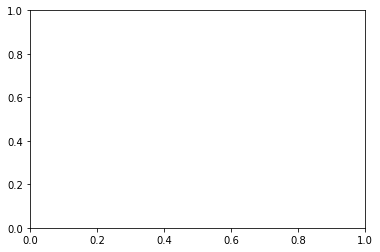

In [1]:
import pandas as pd
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from navipy.trajectories import Trajectory
import os

## Saccade | Intersaccade from body

We aim in this notebook to find a suitable method to classify a bumbleflight trajectory in term of saccade and intersaccade from the orientation of the thorax during a time interval $\Delta t$. 

$$ C(t) = f( w_z^\text{thorax}(t-n), \cdots, w_z^\text{thorax}(t+n) )$$

here:

* $C(t)$ is the class (intersaccade or saccade) at time t
* $f$ is a classifier function
* $w_z^\text{thorax}$ is the angular velocity in the thorax coordinate system around the z axis
* $n$ is the n obersvation such that $2n\approx\Delta$

In article without the head orientation, researchers have often applied a threshold on the angular velocity of the bumbleflight's thorax. Choosing such threshold is done by the researcher in order to yield an visually acceptable classification (i.e. a treadoff between the slow fluctuation are not considered as saccade and large fluctation are considered as saccade). In our analysis, we applied such technique on the bumbleflight's head orientation, which tend to be more stabilised during intersaccade than the body, and turn at higher angular velocity over shorter timespan during saccades than the thorax. We will use such classification based on the bumbleflight's head orientation as the target for our classifier. 

To establish a benchmark, we applied the thresholding technique on the bumbleflight's thorax by choosing the thresholds such as the maximise the accuracy of the classification (by using the bumbleflight's head saccade as reference). 

Our aim is to outperform the benchmark. Note that in research without bumbleflight's head orientation, the thresholds are visually chosen and thus may not be as an optimal choice as for our benchmark. 

### Which classifier to use

Numerous classifiers have flightn develop over the last decades. However, not all classifier - despite yielding good classification - can be easily interpreted. Although classification of bumbleflight's thorax orientation as saccade and intersaccade as practical scope, understanding the classification may yield to genuine understanding to the generation of saccade and intersaccade during bumbleflight's flights. Thus, we will focus here on classifier that can be interpreted in a relatively simple manner. We will thus focus on Decision trees and random forest classifier. The former can be seen as a succesion of if/else conditions, the later as multiple decision trees. 

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Where are the data

The flight trajectories are stored in hdf files

In [3]:
# Load list of flights
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')
# Load the results from splitted nonans
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'

## Example

In [4]:
flightid = '07'
assert flightid in flight_ids.values, 'flight id unknwon'

blk_i = 0
key = '/blk_nonans/flight_{}'.format(flightid) 
blknonans = pd.read_hdf(head_filename_result_blocknonans,key)

assert blk_i in blknonans.index, 'Block unknown'

### Load the data
The thorax velocities

In [5]:
key = '/velocities_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
body_velocity = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']

The ground truth (bumbleflight's head saccades)

In [6]:
key = '/res_sac/flight_{}/blk_{}'.format(flightid,blk_i) 
res_sac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']

The benchmark (bumbleflight's body saccades: two thresholds)

In [7]:
res_sac_body = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']

Select non nans:

In [8]:
body_velocity.dropna(inplace=True)

Select 

In [9]:
intersaccade = res_sac_head.loc[body_velocity.index].saccade.isnull()

Create two matrix of obervations - target 
* target
* obervations:
    | $w_z^\text{thorax}(t-n)$ |  $\cdots$ | $w_z^\text{thorax}(t+n)$ |

In [10]:
n = 51

In [11]:
target = intersaccade.copy()
observation = body_velocity.zyx.dalpha_2.copy() # angular vel around z axis
list_of_values = []
a = observation.rolling(n, center=True).apply(lambda x: list_of_values.append(x.values) or 0, raw=False)
observations = pd.DataFrame(list_of_values, index=a.dropna().index, columns=np.arange(n)-n//2)
# Lets check that we did not do a mess
# the observations at time shift 0, should match the observation at the same index
assert np.all(observations.loc[:,0] == observation.loc[observations.index]), \
    "Problem with building observations"
# Select target to have two align matrices
target = target.loc[observations.index]
# benchmark
benchmark = res_sac_body.loc[target.index].saccade.isnull()

observations.head()

-25       -24       -23       -22       -21       -20       -19  \
1101.0  0.000134  0.000231  0.000303  0.000500  0.000834  0.001265  0.001721   
1102.0  0.000231  0.000303  0.000500  0.000834  0.001265  0.001721  0.002162   
1103.0  0.000303  0.000500  0.000834  0.001265  0.001721  0.002162  0.002475   
1104.0  0.000500  0.000834  0.001265  0.001721  0.002162  0.002475  0.002607   
1105.0  0.000834  0.001265  0.001721  0.002162  0.002475  0.002607  0.002566   

             -18       -17       -16  ...        16        17        18  \
1101.0  0.002162  0.002475  0.002607  ... -0.002626 -0.002683 -0.002699   
1102.0  0.002475  0.002607  0.002566  ... -0.002683 -0.002699 -0.002686   
1103.0  0.002607  0.002566  0.002349  ... -0.002699 -0.002686 -0.002608   
1104.0  0.002566  0.002349  0.001881  ... -0.002686 -0.002608 -0.002499   
1105.0  0.002349  0.001881  0.001136  ... -0.002608 -0.002499 -0.002426   

              19        20        21        22        23        24        25  
1101.0 -0.002686 -0.002608 -0.002499 -0.002426 -0.002338 -0.002169 -0.001909  
1102.0 -0.002608 -0.002499 -0.002426 -0.002338 -0.002169 -0.001909 -0.001621  
1103.0 -0.002499 -0.002426 -0.002338 -0.002169 -0.001909 -0.001621 -0.001430  
1104.0 -0.002426 -0.002338 -0.002169 -0.001909 -0.001621 -0.001430 -0.001475  
1105.0 -0.002338 -0.002169 -0.001909 -0.001621 -0.001430 -0.001475 -0.001768  

[5 rows x 51 columns]

Split the data as training and testing set
* Training on the first 70% of the flight
* Testing on the last 30%

In [12]:
from sklearn.model_selection import train_test_split 
split = train_test_split(target, test_size=0.3, shuffle=False) # shuffle false because first/last part of flight
train_x, train_y, train_b = observations.loc[split[0].index], target.loc[split[0].index], benchmark.loc[split[0].index]
test_x, test_y, test_b = observations.loc[split[1].index], target.loc[split[1].index], benchmark.loc[split[1].index]

Train

In [13]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(train_x.values, train_y.values)

DecisionTreeClassifier(max_depth=10)

In [14]:
from sklearn.metrics import accuracy_score

pred_y = clf.predict(np.squeeze(test_x))
score_classifier = accuracy_score(test_y, pred_y)
score_benchmark = accuracy_score(test_y, test_b)
print(score_classifier, 'vs', score_benchmark)

0.8172124904798173 vs 0.8377760853008378


The decision tree outperform the threshold method